# Coral Reef Dataset Exploration
This notebook explores the CoralConditionDataset (https://github.com/XL-SHAO/CoralConditionDataset), a patch-labeled dataset for coral health monitoring. Unlike the pixel-level annotations in our previous dataset, this one provides image patches with condition-based labels (e.g. "Healthy coral", "Disease").

Some questions the exploration aims to answer are:
* What file formats are used for the data?
* How are annotations stored and what fields do they include?
* Do all images have the same size dimensions?
* What are the color channels?
* What is the label distribution? 
* Is the dataset balanced? If not, how severe is the imbalance?
* Are there ambiguous labels?
* How many annotations exist per image?
* Are there images with no annotations?
* Is the dataset suitable for developing an AI system for coral monitoring?

In [31]:
# Correct working directory.
# This is necessary for imports because the notebook is not in the main folder of the project.
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
from collections import Counter

from data.coral_condition_dataset import CoralConditionDataset

## 1. Dataset Initialization and Basic Properties
The dataset consists of four parts:
1) A CSV file containing the image patch id and its corresponding classification label id(s).
2) A CSV file containing the set of possible labels that can be assigned to the objects within the images with their label ids.
3) A CSV file containing additional information about the images like the sites/locations, date they were taken at, etc...
4) A folder containing underwater patch images of coral reefs.

In [32]:
# Initialize dataset
dataset = CoralConditionDataset()
annotations = dataset.ANNOTATIONS_PATH.copy()
labelset = dataset.LABELSET_PATH.copy()
images_dir = dataset.IMAGES_PATH

# Images in directory
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

# Basic statistics
print(f"Total images in images folder: {len(image_files)}")
print(f"Total annotated images: {annotations['patchid'].nunique()}")
print(f"Total possible labels: {len(labelset)}")
print(f"Total annotations: {len(annotations)}")
print(f"Annotation columns: {list(annotations.columns)}")

# Display labelset
display(labelset)
# Display sample of annotations
annotations.head()

Total images in images folder: 25546
Total annotated images: 23935
Total possible labels: 9
Total annotations: 23965
Annotation columns: ['patchid', 'label']


,label,label_name
0,0,Background
1,1,Healthy coral
2,2,Compromised coral
3,3,Dead coral
4,4,Rubble
5,5,Competition
6,6,Disease
7,7,Predation
8,8,Physical issues


,patchid,label
0,CBK_0001_00_20230804_0001_1,0
1,CBK_0001_00_20230804_0001_2,0
2,CBK_0001_00_20230804_0001_3,0
3,CBK_0001_00_20230804_0001_4,0
4,CBK_0001_00_20230804_0001_5,0


There are 25,546 images in the images folder, while we have 23,935 images recorded in the CSV file. This indicates we have images that have not been labeled and should probably be removed from the dataset during the preprocessing phase.

The labelset contains 9 possible classes. Four labels reflect the coral conditions: Healthy coral, Compromised coral, Dead coral, and Rubble; and four labels reflect stressors: Competition, Disease, Predation, and Physical issues. The last label is Background. There are no ambigious labels that we need to decipher.

The annotations CSV file contains 23,935 entries (one for each patch image) and records these features:
- **patchid**: Filename of the corresponding coral patch image.
- **label**: Label id referring to the labelset CSV file.

Since there are images that have not been labeled, we will also explore if all labeled images do in fact exist in the images folder.

In [3]:
# Check if all annotated patches have corresponding image files
existing_images = {os.path.splitext(f)[0] for f in os.listdir(images_dir)}
missing_images = []
for patch_id in annotations["patchid"].unique():
    if patch_id not in existing_images:
        missing_images.append(patch_id)

# Report results
if not missing_images:
    print("All annotations have corresponding images.")
else:
    print(f"{len(missing_images)} missing images (sample): {missing_images[:5]}")
    print("\nFull list saved to 'missing_images.txt'.")
    with open("missing_images.txt", "w") as f:
        f.write("\n".join(missing_images))

11 missing images (sample): ['AOM_0032_00_20230929_0003_0', 'HNM_0031_00_20230928_0069_0', 'HNM_0031_00_20230928_0070_0', 'HNM_0031_00_20230928_0071_0', 'HNM_0031_00_20230928_0095_0']

Full list saved to 'missing_images.txt'.


After exploring the data integrity we observe that we have 1,611 unannotated images (25,546 - 23,935) and 11 missing images (have annotations but do not exist in the images directory).

Next, we will explore if each image patch receives only one label or can receive multiple labels.

In [4]:
# Detect multi-label entries
annotations['is_multi'] = annotations['label'].apply(lambda x: isinstance(x, str) and ',' in str(x))
multi_label_count = annotations['is_multi'].sum()

print(f"Single-label patches: {len(annotations) - multi_label_count}")
print(f"Multi-label patches: {multi_label_count}")

# Show examples of multi-label entries
display(annotations[annotations['is_multi']].head(3))

Single-label patches: 9677
Multi-label patches: 14288


,patchid,label,is_multi
71,CBK_0001_00_20230804_0003_2,"1,3",True
72,CBK_0001_00_20230804_0003_3,"1,3",True
74,CBK_0001_00_20230804_0003_5,"1,3",True


Since most images are labeled with more than class, it suggests this is a multi-label classification problem.

The sample above showed patches with two labels each, but that might not be the case for all the patches. We'll explore how many labels images typically have. 

In [5]:
# First convert all labels to lists of integers
annotations['label_list'] = annotations['label'].apply(
    lambda x: [int(x)] if isinstance(x, int) else [int(l) for l in str(x).split(',')]
)
# Calculate number of labels per image
annotations['label_count'] = annotations['label_list'].apply(len)
label_counts = annotations['label_count'].value_counts().sort_index()

print(f"Max labels per image: {annotations['label_count'].max()}")
print(label_counts)

Max labels per image: 7
label_count
1    9677
2    8259
3    4181
4    1499
5     322
6      26
7       1
Name: count, dtype: int64


While the majority of patches have 1-3 labels, the number of patches that have 4-7 labels is critical. The 7 labeled patch is an outlier. It makes sense for ecologically complex scenarios to exist, but we need to keep these labels in mind when training the model as it must be able to handle simple binary cases, but also more complex multi-label scenarios. It could also be relevant when splitting the dataset into train/test/validation sets.

Initial observations show: 
- There are images in the dataset that have not been annotated, and may need to be removed.
- 11 images are annotated but are not present in the images dataset, and therefore their annotations may need to be removed. 
- Images in the annotation file are not duplicated (each image corresponds to one annotation row).
- Images can be labeled with one or more classes (multi-label classification).

## 2. Image Data Properties
Before examining the label distribution, we should understand the properties of the image data. 
By manual inspection of the image data we can identify:
* The images all have the same dimensions.
* The images all have a .jpg format.

We will confirm this below:

In [6]:
# Get unique image names from annotations
sampled_images = annotations['patchid'].sample(n=10, random_state=42)
# Print image properties
for img_name in sampled_images:
    try: 
        img = dataset.get_image(img_name)
        img_data = np.array(object=img)
        print(f"{img_name}:", img_data.shape)
    except Exception as err:
        print(f"Error processing {img_name}: {err}")

SKI_0004_00_20230817_0070_22: (512, 512, 3)
HNM_0031_00_20230928_0043_9: (512, 512, 3)
TCB_0003_00_20230816_0107_26: (512, 512, 3)
TCB_0003_00_20230816_0106_20: (512, 512, 3)
SKI_0004_00_20230817_0082_20: (512, 512, 3)
CBK_0001_00_20230804_0071_13: (512, 512, 3)
SKI_0004_00_20230817_0129_22: (512, 512, 3)
HNM_0031_00_20230928_0007_9: (512, 512, 3)
HNM_0031_00_20230928_0011_33: (512, 512, 3)
ALK_0030_11_20230927_0007_7: (512, 512, 3)


In [7]:
# Verify no images exist with different dimensions
inconsistent_dims = []

# Get all unique patch IDs from annotations
all_patch_ids = dataset.ANNOTATIONS_PATH['patchid'].unique()

for patch_id in all_patch_ids:
    try:
        img = dataset.get_image(patch_id)
        img_array = np.array(img)
        if img_array.shape != (512, 512, 3):
            inconsistent_dims.append((patch_id, img_array.shape))
    except Exception as e:
        print(f"Error checking {patch_id}: {e}")

# Display results
if not inconsistent_dims:
    print("All images are (512, 512, 3)")
else:
    print(f"Found {len(inconsistent_dims)} images with different dimensions:")
    for patch_id, shape in inconsistent_dims[:5]:
        print(f"{patch_id}.jpg: {shape}")

Error checking AOM_0032_00_20230929_0003_0: [Errno 2] No such file or directory: 'data/coral_condition/images\\AOM_0032_00_20230929_0003_0.jpg'
Error checking HNM_0031_00_20230928_0069_0: [Errno 2] No such file or directory: 'data/coral_condition/images\\HNM_0031_00_20230928_0069_0.jpg'
Error checking HNM_0031_00_20230928_0070_0: [Errno 2] No such file or directory: 'data/coral_condition/images\\HNM_0031_00_20230928_0070_0.jpg'
Error checking HNM_0031_00_20230928_0071_0: [Errno 2] No such file or directory: 'data/coral_condition/images\\HNM_0031_00_20230928_0071_0.jpg'
Error checking HNM_0031_00_20230928_0095_0: [Errno 2] No such file or directory: 'data/coral_condition/images\\HNM_0031_00_20230928_0095_0.jpg'
Error checking ALK_0030_11_20230927_0019_0: [Errno 2] No such file or directory: 'data/coral_condition/images\\ALK_0030_11_20230927_0019_0.jpg'
Error checking ALK_0030_11_20230927_0026_0: [Errno 2] No such file or directory: 'data/coral_condition/images\\ALK_0030_11_20230927_0026

We can confirm that all images have the same dimensions: 512 x 512 and have 3 color channels. This will make things simpler and means we don't have to worry about formatting sizes during the preprocessing phase.

The errors thrown can be ignored as they are a result of the 11 images that have entries in the annotation file, but are missing from our dataset.

## 3. Tabular Data Properties
Next, we will explore the tabular dataset (annotations CSV file).

In [8]:
# Check for any missing values
print("Missing Patch IDs:", annotations["patchid"].isna().sum())
print("Missing Labels:", annotations["label"].isna().sum())

Missing Patch IDs: 0
Missing Labels: 0


Since there are no missing values, this will not be an issue during pre-processing of the data.

We can now check the label distribution to see how balanced the dataset is.

,Count,Percentage,Num_Patches
label_list,,,
Healthy coral,17332,37.27,17332
Dead coral,9193,19.77,9193
Compromised coral,6916,14.87,6916
Competition,2949,6.34,2949
Disease,2902,6.24,2902
Physical issues,2874,6.18,2874
Rubble,2517,5.41,2517
Background,1092,2.35,1092
Predation,732,1.57,732


Total classes: 9
Majority class: 'Healthy coral' with 17,332 entries
Minority class: 'Predation' with 732 entries
Classes covering 95% of entries: 6


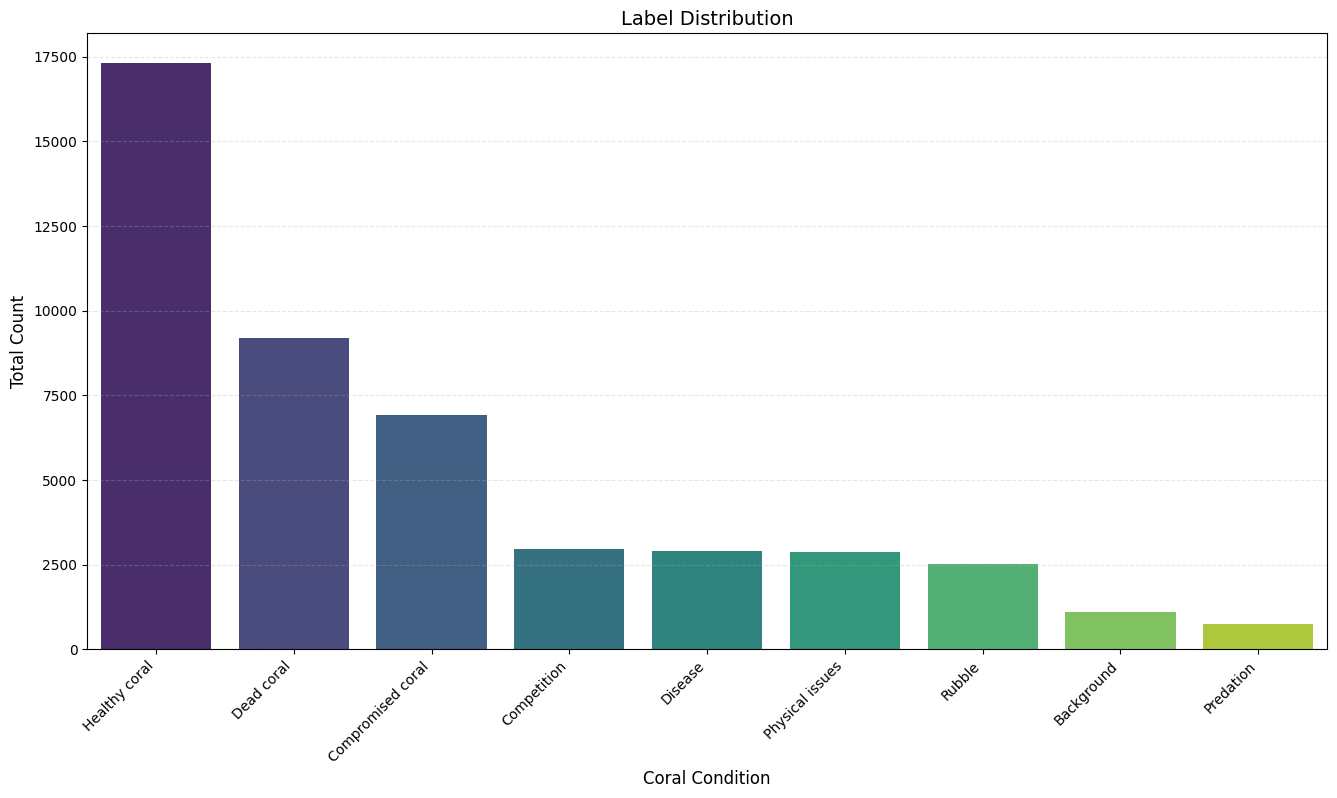

In [9]:
# Count each label occurrence (exploding multi-labels)
exploded_labels = annotations.explode('label_list')
label_dist = exploded_labels['label_list'].value_counts().sort_index()

# Map label IDs to names
label_names = labelset.set_index('label')['label_name']
label_dist.index = label_dist.index.map(label_names)

# Calculate percentages
label_percent = (label_dist / len(exploded_labels) * 100).round(2)

# Create summary dataframe
label_stats = pd.DataFrame({
    'Count': label_dist,
    'Percentage': label_percent,
    'Num_Patches': [sum(annotations['label_list'].apply(lambda x: label in x)) 
                   for label in label_names.index]
}).sort_values('Count', ascending=False)

display(label_stats)

# Get class extremes
majority_class = label_stats['Count'].idxmax()
minority_class = label_stats['Count'].idxmin()

print(f"Total classes: {len(label_stats)}")
print(f"Majority class: '{majority_class}' with {label_stats['Count'].max():,} entries")
print(f"Minority class: '{minority_class}' with {label_stats['Count'].min()} entries")
print(f"Classes covering 95% of entries: {label_stats[label_stats['Percentage'].cumsum() <= 95].shape[0]}")

# Plot configuration
plt.figure(figsize=(16, 8))
ax = sns.barplot(
    x=label_stats.index,
    y=label_stats['Count'],
    hue=label_stats.index,
    palette="viridis",
    legend=False
)

plt.title('Label Distribution', fontsize=14)
plt.xlabel('Coral Condition', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()


The majority class: 'Healthy coral' makes up around 37% of all annotations, while the minority class: 'Predation' makes up around 1.6% of annotations. The top 6 classes are covering 95% of the data. There is an obvious class imbalance, but looks better than the previous dataset we explored.

Another observation is that labels reflecting coral conditions (as opposed to stressors) collectively represent the majority of all classes. In comparison, stressors are underrepresented (about 20% combined).

## 4. Multi-Label Distribution
To further explore the dataset's label distribution, we can observe which classes appear together in multi-labeled image patches.

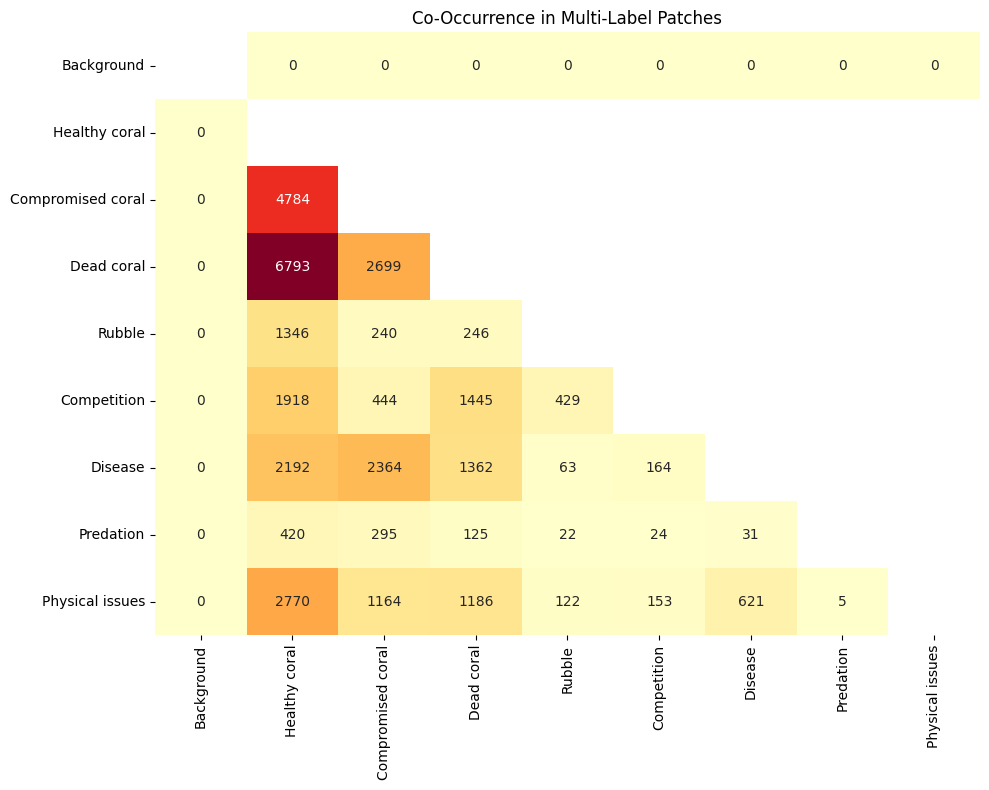

In [10]:
# Create co-occurrence matrix
working_annotations = dataset.get_preprocessed_annotations()
co_occurrence = dataset.binary_matrix.T @ dataset.binary_matrix 

# Convert to readable names
co_occurrence.index = co_occurrence.index.map(labelset.set_index('label')['label_name'])
co_occurrence.columns = co_occurrence.index

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlOrRd',
            mask=np.triu(co_occurrence), cbar=False)
plt.title('Co-Occurrence in Multi-Label Patches')
plt.tight_layout()
plt.show()

The most frequent combination (6,793 co-occurences) is healthy + dead corals, which should be considered when training the model and probably requires algorithms that are robust to mixed conditions patches. The model should learn that these labels aren't mutually exclusive. From an ecological perspective, it could indicate partial colony mortality where living coral tissue coexist with dead areas. Maybe this could be used as an early warning sign of coral bleaching events or disease outbreaks?

Healthy + compromised (4,784 co-occurences), healthy + physical issues (2,770 co-occurences), and healthy + disease (2,192 co-occurences) can also maybe indicate early-stage stress progression, and should be taken into account when training the model to better detect the difference between the coral conditions.

It is a bit surprising that physical issues + healthy coral (2,770 patches) occurs more often than physical issues + dead coral (1,186) but a possible reason could be that physical damage like breakage affects living coral before death?

Disease + compromised coral (2,364 co-occurences) and compromised + dead coral (2,699 co-occurences) are frequently present together in one image patch. These combinations make sense, but again the model should be sensitive to the subtle differences between the coral conditions.

Dead coral + competition (1,445 co-occurences) could mean that organisms take the opportunity to colonize dead corals. We should try to prevent the model from misclassifying competition as just dead coral. 

Background never exists with other labels which might be good to reduce noise while training the model. 

Since the above matrix is binary, it will only display patches with 2 labels. We'll observe image patches with 3 or more labels.

In [11]:
# Generate all possible label combinations with 3 to max labels per patch
all_combinations = []
for labels in annotations['label_list']:
    if len(labels) >= 3:
        for r in range(3, len(labels)+1):
            all_combinations.extend(combinations(sorted(labels), r))

# Count frequency of each combination
combo_counts = Counter(all_combinations)

# Format with label names
combo_stats = []
for combo, count in combo_counts.most_common(20):  # Top 20
    combo_names = [labelset.loc[l, 'label_name'] for l in combo]
    combo_stats.append({
        'labels': combo,
        'label_names': " + ".join(combo_names),
        'count': count,
        'size': len(combo)
    })

combo_df = pd.DataFrame(combo_stats)
combo_df.head(10)

,labels,label_names,count,size
0,"(1, 2, 3)",Healthy coral + Compromised coral + Dead coral,2177,3
1,"(1, 2, 6)",Healthy coral + Compromised coral + Disease,1699,3
2,"(1, 3, 8)",Healthy coral + Dead coral + Physical issues,1147,3
3,"(1, 3, 6)",Healthy coral + Dead coral + Disease,1139,3
4,"(1, 2, 8)",Healthy coral + Compromised coral + Physical i...,1082,3
5,"(1, 3, 5)",Healthy coral + Dead coral + Competition,1030,3
6,"(2, 3, 6)",Compromised coral + Dead coral + Disease,1025,3
7,"(1, 2, 3, 6)",Healthy coral + Compromised coral + Dead coral...,843,4
8,"(1, 6, 8)",Healthy coral + Disease + Physical issues,594,3
9,"(2, 3, 8)",Compromised coral + Dead coral + Physical issues,594,3


The most frequent label combinations across patches labeled with three or more classes are healthy + compromised + dead coral (2,177 patches) and healthy + compromised + disease (1,699 patches). This could indicate a progressive coral decline within a single patch. Hopefully, we can get the model to recognize intermediate states between healthy and dead coral tissue (coral discoloration is relevant here for the model to focus on). Maybe augmenting the dataset with stressors can help with recognizing different coral conditions (e.g. adding localized noise to stimulate spread of disease)?

For coral health monitoring, these combinations represent transitional states that are critical for early intervention. A model trained on single label data might miss that.

One limitation to consider is that as opposed to pixel-level annotation, patch-level annotations show less precise localization of coral conditions, but this also better reflects ecological reality, and reflects real-world monitoring constraints which can be maybe be acknowledged by choosing appropriate confidence scores. 

Multi-label exploration can explain the dataset's class imbalance seen earlier. The Normalized Pointwise Mutual Information (NPMI) can help analyze label co-occurences by quantifying the link between the classes. We can use it to explore relationships between labels and see how strongly/weakly linked they are (occurring together). It can also help reveal true ecological relationships instead of count/frequency occurences, and normalize for class imbalance. 

Its output can be explained as follows:
* **<0**: Labels co-occur less than expected.
* **=0**: Labels are independent. 
* **>0**: Labels co-occur more than random chance.

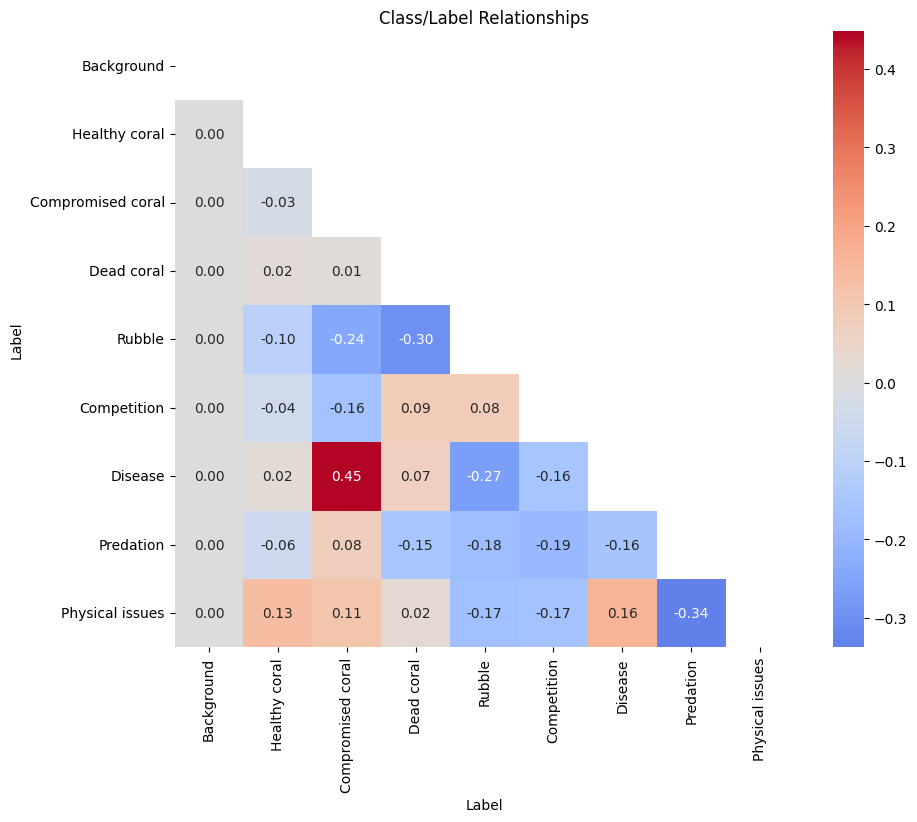

In [13]:
# Initialize NPMI matrix
npmi_matrix = pd.DataFrame(
    index=labelset['label_name'],
    columns=labelset['label_name'],
    dtype=float
)

# Calculate NPMI for all label pairs
for l1 in labelset['label']:
    for l2 in labelset['label']:
        if l1 != l2:
            # Joint probability P(l1 and l2)
            p_joint = ((dataset.binary_matrix[l1] == 1) & (dataset.binary_matrix[l2] == 1)).mean()
            # Individual probabilities P(l1), P(l2)
            p_l1 = (dataset.binary_matrix[l1] == 1).mean()
            p_l2 = (dataset.binary_matrix[l2] == 1).mean()
            
            # NPMI calculation
            if p_joint > 0:
                npmi = (np.log(p_joint) - np.log(p_l1 * p_l2)) / -np.log(p_joint)
            else:
                npmi = 0
            npmi_matrix.loc[labelset.loc[l1, 'label_name'], 
                           labelset.loc[l2, 'label_name']] = npmi

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(
    npmi_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    mask=np.triu(np.ones_like(npmi_matrix)))
plt.xlabel('Label')
plt.ylabel('Label')
plt.title("Class/Label Relationships")
plt.show()

Our earlier observation on number of co-occurences showed a high co-occurence between healthy and dead corals (6,793 co-occurences), and healthy + compromised (4,784 co-occurences). Though they appeared together the most out of all our 2 label patches, the NPMI score shows more accurate relationships between them, which are weakly linked (healthy + dead: 0.02, healthy + compromised: -0.03). The strongest relationship a healthy coral has with other labels is physical issues (0.13). High NPMI between compromised and disease (0.45) indicates detecting compromised coral may help predict disease outbreaks. If the model learns class relationships, especially strongly linked pairs (like disease + compromised), then it might improve the model's accuracy. This dataset balance should be preserved as it helps portray the reality of the ecological environment.

We can extend NPMI to measure how much more likely a label appears in specific multi-label contexts. We can Calculate NPMI for how much a context (set of labels) affects the probability of a target label compared to its baseline frequency (is presence regardless of context): P(target | context) vs. P(target).

In [14]:
npmi = dataset.multi_label_npmi(
    context_labels=["Healthy coral", "Compromised coral"],
    target_label="Dead coral"
)
print(f"NPMI: Dead coral given Healthy + Compromised coral: {npmi:.2f}")

# Print interpretation
if npmi > 0.5:
    print("STRONG association (very likely to co-occur)")
elif npmi > 0.2:
    print("MODERATE association (somewhat likely to co-occur)")
elif npmi > -0.2:
    print("WEAK or no association (co-occurs randomly)")
else:
    print("AVOIDANCE (rarely appears together)")

NPMI: Dead coral given Healthy + Compromised coral: 0.07
WEAK or no association (co-occurs randomly)


Seeing Healthy + Compromised coral only slightly increases the chance of Dead coral in the dataset. Possible reasons are Dead coral is common in the dataset (high baseline), and the three labels are rarely marked together.

In [15]:
npmi = dataset.multi_label_npmi(
    context_labels=["Disease", "Predation", "Dead coral"],
    target_label="Rubble"
)
print(f"NPMI: Rubble given Disease + Predation + Dead coral: {npmi:.2f}")
# Print interpretation
if npmi > 0.5:
    print("STRONG association (very likely to co-occur)")
elif npmi > 0.2:
    print("MODERATE association (somewhat likely to co-occur)")
elif npmi > -0.2:
    print("WEAK or no association (co-occurs randomly)")
else:
    print("AVOIDANCE (rarely appears together)")

NPMI: Rubble given Disease + Predation + Dead coral: 0.00
WEAK or no association (co-occurs randomly)


These labels appear together no more/less than expected by random chance. It suggests rubble forms independently of disease, predation and dead corals in the dataset.

One thing to keep in mind is that what the NPMI measures is how how much more or less frequently labels appear together compared to random chance, and does not indicate causation. In addition, it is based only on annotation patterns in our dataset, and therefore does not reveal real-world probabilities but just the dataset's specific frequencies. Therefore, it should not represent absolute ecological truth, instead, just labeling tendences.

Taking this into consideration, we should aim for the model to learn from the relationships but also avoid overfitting.

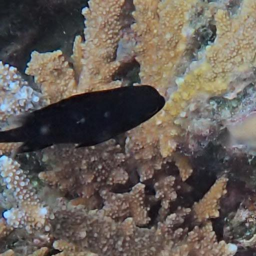

Labels: ['Healthy coral', 'Compromised coral', 'Dead coral']


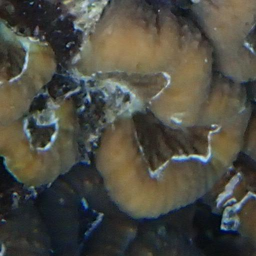

Labels: ['Healthy coral', 'Compromised coral', 'Dead coral', 'Disease']


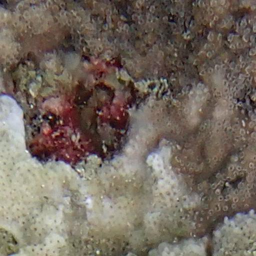

Labels: ['Healthy coral', 'Compromised coral', 'Dead coral', 'Physical issues']


In [30]:
# Visualize some of the images 
sample = annotations[annotations['label_list'].apply(
    lambda x: {1, 2, 3}.issubset(x)  # Healthy+Compromised+Dead
)].sample(3)
for _, row in sample.iterrows():
    img = dataset.get_image(row['patchid'])
    display(img.resize((256, 256)))
    print("Labels:", [labelset.loc[l, 'label_name'] for l in row['label_list']])

## Conclusion

This dataset is better suited for coral health monitoring than the previous one because:
* Labels directly indicate health/stress conditions.
* Complete patch labeling avoids sparse annotation issues.
* No misaligned annotations (unlike the pixel-level dataset).
* Same format and dimension images simplify model input.
* Multi-label annotations capture real-world complexity (e.g. partially dead colonies).
* The imbalance doesn't seem significant and can approaches can be taken for it (e.g. rare classes often co-occur with common ones (like Physical issues with Healthy coral), enabling targeted oversampling).
